#### 1. Train data set is visualized in several ways using swarmplot in seaborn to provide guidelines for feature engineering followed by one-hot encoding. A total of 6 features are used:
#### (1) Pclass and Sex are used without any modification,
#### (2) Fare is binned into 4 groups with 'unknown' and by using bin edges 10.5 and 75,
#### (3) SibSp and Parch are added together and binned to unkown, 0 (travel alone), 4 below, and 4 and above to form a new feature,
#### (4) Persons with 'Master' in Name are identified and form a new feature,
#### (5) Female in Pclass 3 with Fare > 24 is identified and forms a new feature, 
#### 2. Eight models with hyper-parameter tuning are constructed for predictions: logistic regression, random forest, gradient boosting, XGBoost, multinomial naive Bayes, k nearest neighbors, stack, and majority vote. The stack model uses all the first 6 models above as the 1st-level models and random forest as the 2nd-level model. 
#### 3. In summary, gradient boost and stack models have the highest mean cross-validation scores (both 0.842), followed by random forest and XGBoost (0.837 and 0.836, respectively), followed by logistic regression and k nearest neighbors (0.828 and 0.827, respectively), and multinomial naive Bayes has the lowest score of 0.780.
#### However, random forest, together with stack, achieve the highest public scores of 0.799, followed by logistic regression, gradient boost, and XGBoost (all 0.794), followed by k nearest neighbors with 0.789, and multinomial naive Bayes has the lowest public score of 0.746. The majority vote also achieves the highest public score of 0.799.
#### It is found that model performance (model's public score) may be highly dependent on the number of features chosen and the ways the features are enginnered.

In [2]:
%autosave 0

Autosave disabled


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from scipy.stats import uniform, norm
%matplotlib inline

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
import sklearn

## Data visualization

In [5]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
sns.set(style='darkgrid')
colors = ['darkred', 'darkseagreen']

### 1. Visualize the survival chance of persons with different fare

In [8]:
data_train[data_train['Fare'] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


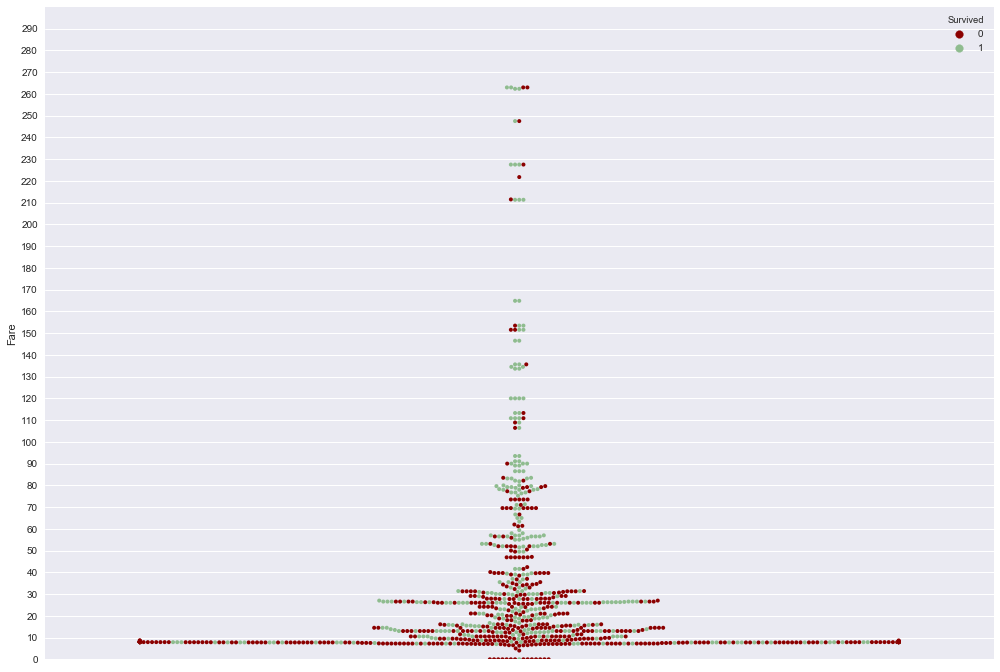

In [9]:
fig, ax = plt.subplots(figsize=(17,12))
ax.set_ylim(0, 300)
ax.set_yticks(np.arange(0, 300, 10))
sns.swarmplot(y=data_train['Fare'], x=[""]*len(data_train), size=4, 
              hue=data_train['Survived'], palette=colors)

#### The plot above shows that persons with fare above 75 had a relatively good chance of survival, and those with fare below about 10.5 the chance was quite bad, and those with fare in between seems to have a chance somewhere in the middle. 

### 2. Add 'SibSp' and 'Parch' together and visualize the chance of survival

In [10]:
df_try = data_train.copy()
df_try['SibSp_Parch'] = df_try['SibSp'] + df_try['Parch']
df_try.groupby('SibSp_Parch')['Survived'].value_counts()

SibSp_Parch  Survived
0            0           374
             1           163
1            1            89
             0            72
2            1            59
             0            43
3            1            21
             0             8
4            0            12
             1             3
5            0            19
             1             3
6            0             8
             1             4
7            0             6
10           0             7
Name: Survived, dtype: int64

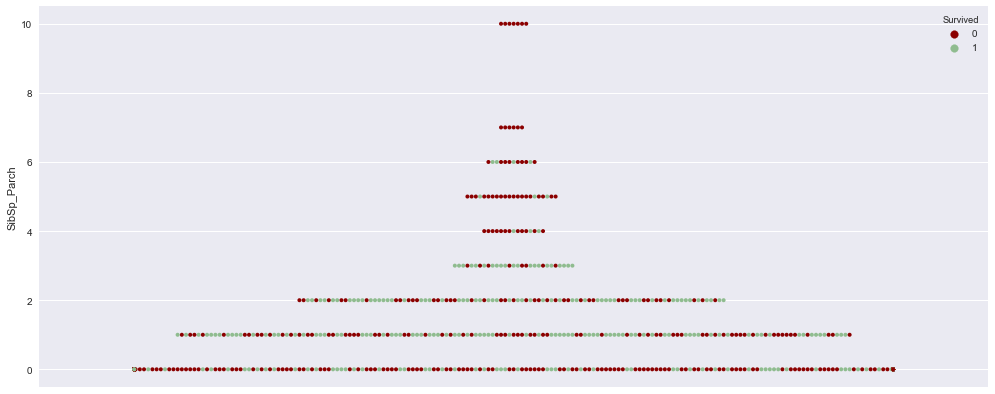

In [11]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.swarmplot(y=df_try['SibSp_Parch'], x=[""]*len(df_try), size=4, hue=df_try['Survived'], 
              palette=colors)

#### The plot above shows that persons with 4 relatives or above had a relatively small chance of survival, and the same is true (to a lesser extent) with persons who traveled alone with 0 relatives. In contrast, persons with 1 to 3 relatives had a better chance of survival.   

### 3. Visualize chance of survival in plots combining sex, age, and Pclass

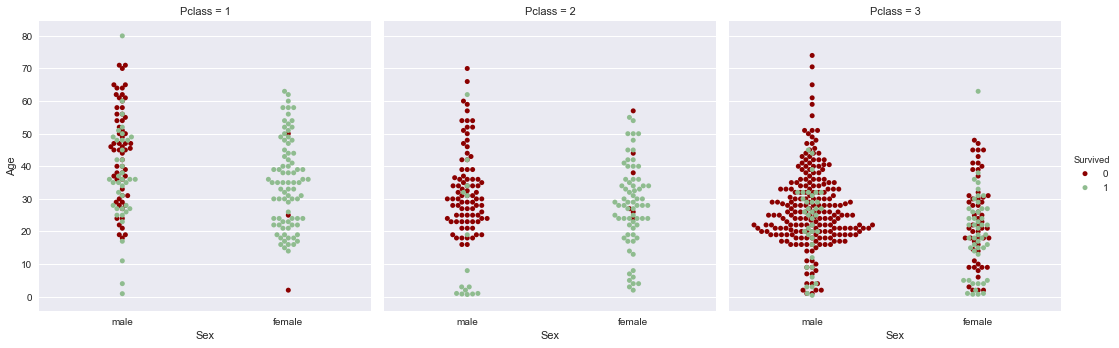

In [12]:
g1 = sns.FacetGrid(data_train, col='Pclass', hue='Survived', palette=colors, size=5, aspect=1)
g1 = g1.map(sns.swarmplot, 'Sex', 'Age', order=['male', 'female'], size=5)
g1.add_legend()

#### It can be seen from the plot above that male with age less than about 12 years old had a better chance of survival compared to male older than this age. We will later create a new feature to reflect this.

In [13]:
mask_master = pd.Series('Master' in i for i in data_train['Name'])
data_train[mask_master].sort_values('Age', ascending=False).head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
125,126,1,3,"Nicola-Yarred, Master. Elias",male,12.0,1,0,2651,11.2417,NaN,C
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
165,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
489,490,1,3,"Coutts, Master. Eden Leslie ""Neville""",male,9.0,1,1,C.A. 37671,15.9000,NaN,S
549,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q


#### From the table above it can be seen that if a person has 'Master' in 'Name' then this person is a male with age less than or equal to 12 years old.

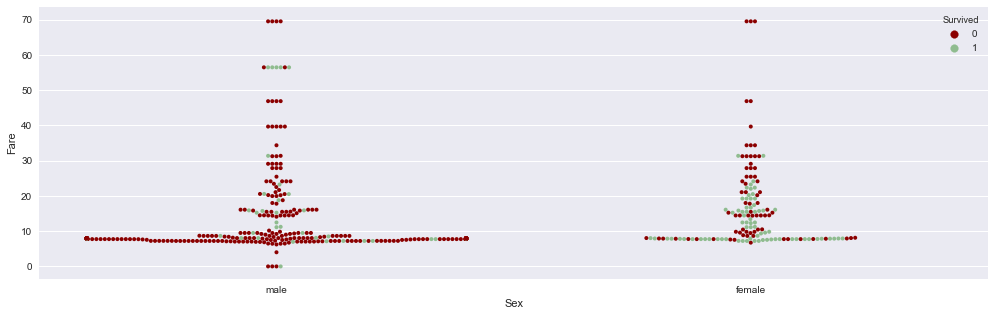

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
sns.swarmplot(x='Sex', y='Fare', data=data_train[data_train['Pclass']==3], size=4, 
              hue='Survived', palette=colors)

#### It can be seen from the plot above that female in Pclass 3 with fare greater than about 24 almost all did not make it. We will also later create a new feature to reflect this.

## Data cleaning and preprocessing

In [15]:
y = data_train['Survived']
X = data_train.drop('Survived', axis=1)
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
def combine_Sib_Par(df):
    """Sum the two columns SibSp and Parch together."""
    df['SibSp_Parch'] = df['SibSp'] + df['Parch']

def add_name_master_feature(df):
    """Create a new feature: if Master in Name, then Yes, otherwise, No."""
    mask_master = pd.Series('Master' in i for i in df['Name'])
    df1 = df['Name'].mask(mask_master, 'Yes')
    df['Name_Master'] = df1.where(mask_master, 'No')    
    
def add_female_pclass_3_high_fare_feature(df):
    """Create a new feature: if female, in Pclass 3, and Fare > 24, Yes, otherwise, No."""
    df_temp = df[((df['Pclass']==3) & (df['Sex']=='female')) & (df['Fare']>24.)]
    mask = df.index.isin(df_temp.index)
    df['Fem_Hfare_Pcl3'] = pd.Series(range(df.shape[0])).mask(mask, 'Yes')
    df['Fem_Hfare_Pcl3'] = df['Fem_Hfare_Pcl3'].where(mask, 'No')

def drop_feature(df):
    df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], \
            axis=1, inplace=True)
    
def fill_feature(df):
    """Fill all NaN values."""
    df['Pclass'] = df['Pclass'].fillna(-1)
    df['Sex'] = df['Sex'].fillna('Unknown')
    df['SibSp_Parch'] = df['SibSp_Parch'].fillna(-1)
    df['Fare'] = df['Fare'].fillna(-0.5)

def bin_fare_and_SibSpParch(df):
    """Bin Fare and SibSp_Parch based on previous visualization results."""
    bins = (-1, 0, 10.5, 75, 1500)
    group_names = ['Unknown', '10.5_below', '10.5_to_75', '75_above']
    df['Fare'] = pd.cut(df['Fare'], bins, labels=group_names, right=False)
    
    bins = (-1, -0.1, 0.1, 4, 50)
    group_names = ['Unknown', '0', '4_below', '4_above']
    df['SibSp_Parch'] = pd.cut(df['SibSp_Parch'], bins, labels=group_names, right=False)

def data_transform(df):
    combine_Sib_Par(df)
    add_name_master_feature(df)
    add_female_pclass_3_high_fare_feature(df)
    drop_feature(df)
    fill_feature(df)
    bin_fare_and_SibSpParch(df)

In [17]:
data_transform(X)

In [18]:
X.head(10)

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,4_below,No,No
1,1,female,10.5_to_75,4_below,No,No
2,3,female,10.5_below,0,No,No
3,1,female,10.5_to_75,4_below,No,No
4,3,male,10.5_below,0,No,No
5,3,male,10.5_below,0,No,No
6,1,male,10.5_to_75,0,No,No
7,3,male,10.5_to_75,4_above,Yes,No
8,3,female,10.5_to_75,4_below,No,No
9,2,female,10.5_to_75,4_below,No,No


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass            891 non-null int64
Sex               891 non-null object
Fare              891 non-null category
SibSp_Parch       891 non-null category
Name_Master       891 non-null object
Fem_Hfare_Pcl3    891 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 30.0+ KB


In [20]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_1 = ohe.fit_transform(X).toarray()
list(X_1)[:5] 

[array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])]

In [21]:
ohe.categories_

[array([1, 2, 3], dtype=int64),
 array(['female', 'male'], dtype=object),
 array(['10.5_below', '10.5_to_75', '75_above'], dtype=object),
 array(['0', '4_above', '4_below'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [22]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Fare_10.5_below', 'Fare_10.5_to_75', 'Fare_75_above',
       'SibSp_Parch_0', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_No', 'Name_Master_Yes', 'Fem_Hfare_Pcl3_No',
       'Fem_Hfare_Pcl3_Yes'], dtype=object)

In [23]:
# Create a DataFrame for correlation plot
X_1_frame = pd.DataFrame(X_1, columns=x_ax)
X_1_frame.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Fare_10.5_below,Fare_10.5_to_75,Fare_75_above,SibSp_Parch_0,SibSp_Parch_4_above,SibSp_Parch_4_below,Name_Master_No,Name_Master_Yes,Fem_Hfare_Pcl3_No,Fem_Hfare_Pcl3_Yes
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


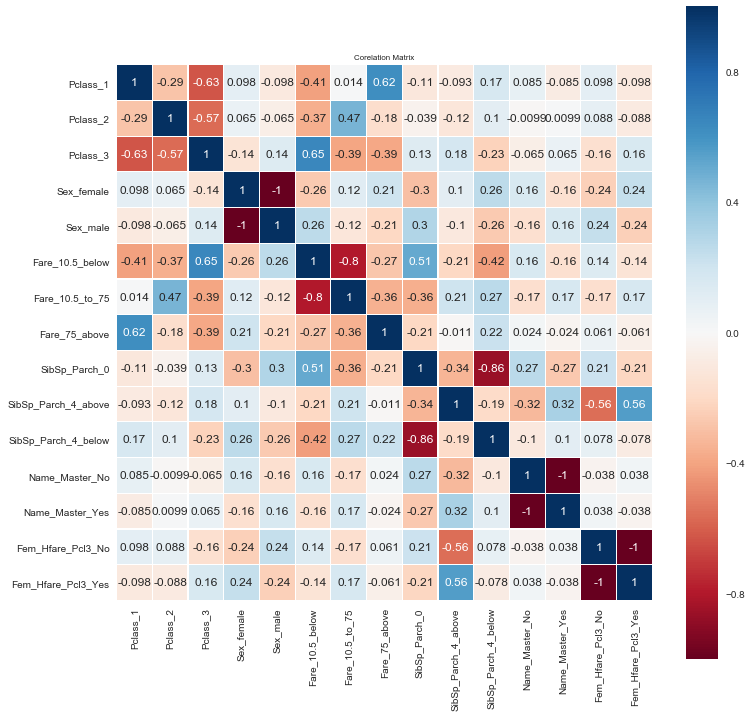

In [24]:
plt.figure(figsize=(12, 12))
plt.title('Corelation Matrix', size=8)
sns.heatmap(X_1_frame.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, 
            linecolor='white', annot=True)
plt.show()

## Data training and parameter tuning

In [25]:
# define a cv splitter
cv_splitter = StratifiedKFold(n_splits=5, random_state=42)

### 1. First Model: Logistic Regressionfrom 


In [26]:
logis = LogisticRegression(solver='liblinear', random_state=42)
C_param = sorted(10**np.random.uniform(-2, 0, size=100))  # log-uniform distrbution from 0.01 to 1
# Since if there are multiple parameter combinations rank first, GridSearchCV will choose the
# first encountered one as the best result, sort the array so the smallest possible C can be 
# picked. 
parameter_grid = {
                'C': C_param,
                'class_weight': ['balanced', None]
                }
grid_logis = GridSearchCV(logis, parameter_grid, cv=cv_splitter, refit=True)
grid_logis.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=Fal...
                               0.03268010218551968, 0.0339466747977833,
                               0.03434462849797251, 0.03698814501371648,
                               0.040255669749541194, 0.04262808942526411,
                               0.04557640981828254, 0.04668139288855613,
                

In [27]:
logis_best_param = grid_logis.best_params_  
logis_best_param
# best parameter values to be used in the stack model

{'C': 0.31627732156176225, 'class_weight': None}

In [28]:
results = pd.DataFrame(grid_logis.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.978386,None,"{'C': 0.9783856697298245, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
143,0.316277,None,"{'C': 0.31627732156176225, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
145,0.318621,None,"{'C': 0.3186213683660766, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
147,0.321341,None,"{'C': 0.3213409591674894, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
151,0.353986,None,"{'C': 0.353986049730384, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
153,0.360239,None,"{'C': 0.3602386549841044, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
177,0.767987,None,"{'C': 0.7679874621990408, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
179,0.771862,None,"{'C': 0.7718616277185719, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
181,0.786591,None,"{'C': 0.7865914292345481, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
149,0.341769,None,"{'C': 0.3417694676350401, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1


In [29]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Fare_10.5_below', 'Fare_10.5_to_75', 'Fare_75_above',
       'SibSp_Parch_0', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_No', 'Name_Master_Yes', 'Fem_Hfare_Pcl3_No',
       'Fem_Hfare_Pcl3_Yes'], dtype=object)

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000256D38B31D0>>

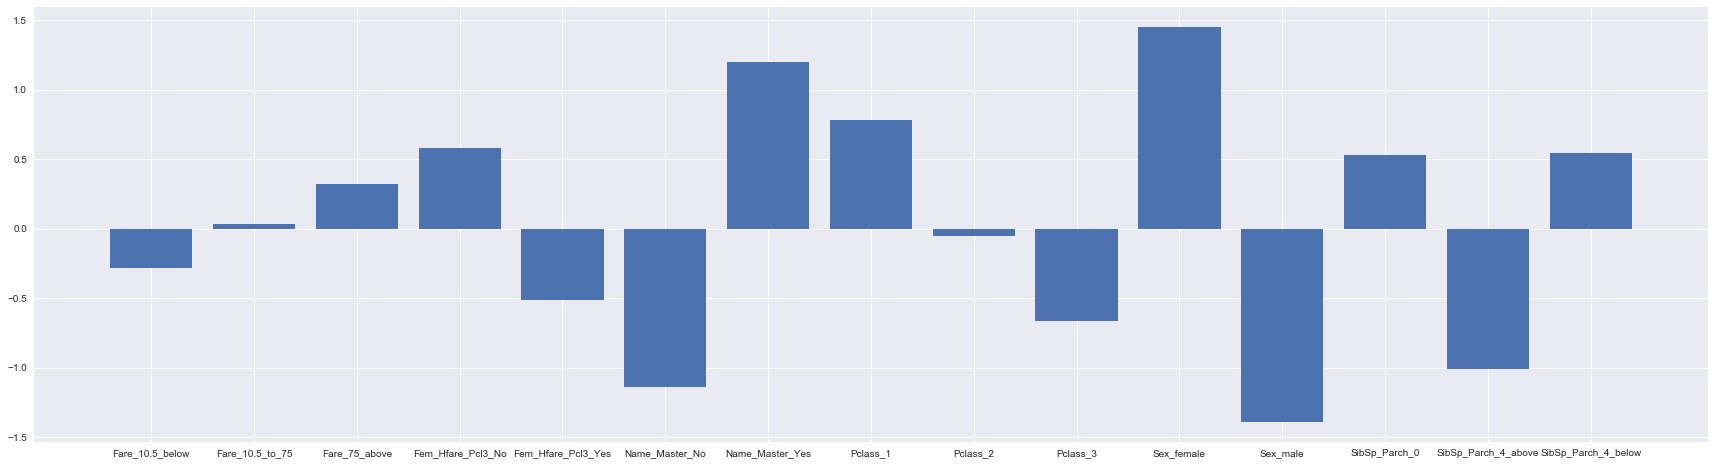

In [30]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(x_ax, grid_logis.best_estimator_.coef_[0])
ax.grid

In [31]:
scores_logis = cross_val_score(grid_logis.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_logis)
print('Mean (logis): '+str(scores_logis.mean()))
print('SD (logis): '+str(scores_logis.std()))

[0.82122905 0.82681564 0.8258427  0.80337079 0.86440678]
Mean (logis): 0.828332991108903
SD (logis): 0.019916825888839272


## Test data preprocessing

In [32]:
data_test = pd.read_csv('test.csv')
passenger_id = data_test['PassengerId']
num_row_test = data_test.shape[0]
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [33]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [34]:
data_transform(data_test)
data_test.head()

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,0,No,No
1,3,female,10.5_below,4_below,No,No
2,2,male,10.5_below,0,No,No
3,3,male,10.5_below,0,No,No
4,3,female,10.5_to_75,4_below,No,No


In [35]:
X_test = ohe.transform(data_test).toarray()
list(X_test)[:5]

[array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.])]

## Model Predictions

### 1. Logistic regression

In [ ]:
y_test_predict_logis = grid_logis.predict(X_test)
submission_logis_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_logis})

existing_file = glob.glob('submission_logis_2.csv')
assert (not existing_file), 'File already existed.'
submission_logis_2.to_csv('submission_logis_2.csv', index=False)
# (This submission got a public score of 0.794)